In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import seaborn as sns
import scipy

## TODO:

1. outlier detection -- z score?
2. better signal extraction

In [2]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
# rc('text', usetex=True)

In [3]:
test_video = 'data/stabilized_video.mp4'
if not os.path.isfile(test_video): raise Exception('invalid video path')

In [4]:
def vid_to_ndarray(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

In [5]:
test_array = vid_to_ndarray(test_video)
print(test_array.shape)
test_smear = np.mean(test_array, axis=0).astype(int)
print(test_smear.shape)

(1414, 480, 480, 3)
(480, 480, 3)


In [6]:
cv_channels = {'b': 0, 'g': 1, 'r': 2}
test_array_green = test_array[:, :, :, cv_channels['g']]
test_array_red = test_array[:, :, :, cv_channels['r']]
test_array_blue = test_array[:, :, :, cv_channels['b']]
print(test_array_green.shape)

(1414, 480, 480)


In [7]:
def resize_mean(array, size):
    t, h, w = array.shape
    h_new, w_new = h//size, w//size
    flattened = np.reshape(array, (t, h_new, size, w_new, size)).swapaxes(2, 3).reshape(t, h_new, w_new, size**2)
    return flattened.mean(axis=-1)

In [8]:
def resize_arbitrary(f, array, size):
    t, h, w = array.shape
    h_new, w_new = h//size, w//size
    flattened = np.reshape(array, (t, h_new, size, w_new, size)).swapaxes(2, 3).reshape(t, h_new, w_new, size**2)
    return f(flattened, axis=-1)

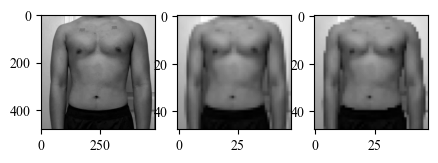

In [9]:
test_array_mean_resize = resize_mean(test_array_green, 10)
test_array_median_resize = resize_arbitrary(np.median, test_array_green, 10)

fig, ax = plt.subplots(1, 3, figsize=(5, 5))
ax[0].imshow(test_array_green[0], cmap='gray')
ax[1].imshow(test_array_mean_resize[0], cmap='gray')
ax[2].imshow(test_array_median_resize[1], cmap='gray')
plt.show()

In [10]:
block_size = 60

n_frames = test_array_green.shape[0]
green_signals = resize_mean(test_array_green, block_size).reshape(n_frames, -1).swapaxes(0, 1)
red_signals = resize_mean(test_array_red, block_size).reshape(n_frames, -1).swapaxes(0, 1)
blue_signals = resize_mean(test_array_blue, block_size).reshape(n_frames, -1).swapaxes(0, 1)
print(green_signals.shape)

(64, 1414)


In [11]:
def chrom(r, g, b, fps, fft=False):

    rgb_mean = (r + g + b) / 3
    Rn, Gn, Bn = r/rgb_mean, g/rgb_mean, b/rgb_mean

    Xs = 3*Rn - 2*Gn
    Ys = 1.5*Rn + Gn - 1.5*Bn

    low_freq = 40/60
    high_freq = 240/60

    iirb, iira = scipy.signal.butter(3, ((2*low_freq)/fps, (2*high_freq)/fps), 'bandpass')

    Xf = scipy.signal.filtfilt(iirb, iira, Xs)
    Yf = scipy.signal.filtfilt(iirb, iira, Ys)

    alpha = np.std(Xf) / np.std(Yf)
    S = Xf - alpha*Yf
    
    if fft:
        S_fft = np.abs(np.fft.rfft(S))
        return S_fft
    else:
        return S

In [12]:
def score_fft(sigfft, fps, k=1):
    
    topk = np.argsort(sigfft)[-k:][::-1]

    return sigfft[topk], topk*60/fps

In [13]:
fps = 30
# sigfft = chrom(rs, gs, bs, fps, fft=True)
# topk_val, topk_bpm = score_fft(sigfft, fps, 10)
# print(topk_val)
# print(topk_bpm)

In [14]:
bpm, bpm_vals = [], []
for i, (r, g, b) in enumerate(zip(red_signals, green_signals, blue_signals)):
    (topk_val,), (topk_bpm,) = score_fft(chrom(r, g, b, fps, fft=True), fps, 1)
    bpm.append(topk_bpm)
    bpm_vals.append(topk_val)
bpm = np.array(bpm)

c:\Users\Tienda\miniconda3\envs\chest-rppg\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

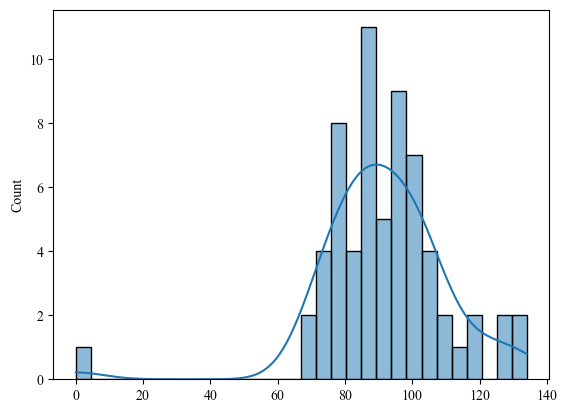

In [15]:
bpm[bpm > 200] = 0
sns.histplot(bpm, bins=30, kde=True)

In [16]:
bpm_2d = bpm.reshape(480//block_size, -1)

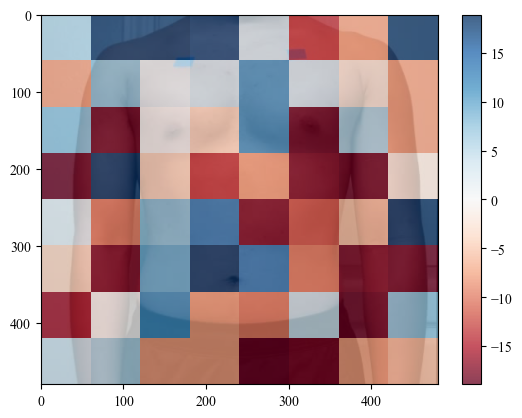

In [17]:
plt.figure()
plt.imshow(test_array[0][:,:,[2,1,0]])
# bound = np.abs(bpm_2d-94).max()
bound = np.std(bpm_2d)
plt.imshow(bpm_2d-94, cmap='RdBu', alpha=0.75, extent=[0, 480, 0, 480], aspect='auto', vmin=-bound, vmax=bound)
plt.colorbar()
plt.ylim(480, 0)
plt.show()

In [18]:
v1 = vid_to_ndarray(test_video)
v2 = vid_to_ndarray('data/marker_raw_480x480_30fps.mp4')

In [19]:
def smear(arr, mean=True):
    if mean:
        return np.mean(arr, axis=0).astype(int)[:,:,[2,1,0]]
    else:
        return np.std(arr, axis=0).mean(axis=-1).astype(int)

C:\Users\Tienda\AppData\Local\Temp\ipykernel_14084\564748652.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


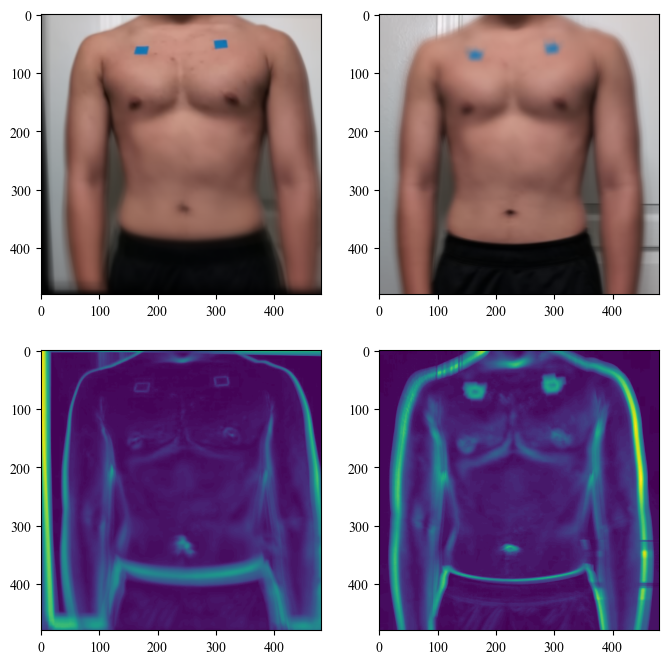

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0][0].imshow(smear(v1, mean=True))
ax[1][0].imshow(smear(v1, mean=False))
ax[0][1].imshow(smear(v2, mean=True))
ax[1][1].imshow(smear(v2, mean=False))
plt.savefig('images/motion_comp.png', bbox_inches='tight')
fig.show()